In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
train_data = pd.read_csv('train.csv')

In [15]:
#Summary of the dimensions.
# X_train is 784 x 41000
# Y_train is 1 x 41000
# One hot Y_train is 10 x 41000 the amount of classes (10)
# m is the number of data points (41000)
# n is the number of features (784)

In [16]:
# (Rows, Columns)
# M is rows n is columns 
# When we transpose the data we get Columns, Rows

data = np.array(train_data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

test_data = data[0:1000].T
Y_test = test_data[0]
X_test = test_data[1:n]
X_test = X_test / 255

#you need to divide X_train and X_test by 255 Normalizing the data
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape


In [17]:
X_train[:,0].shape
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 41000))

In [18]:
Y_train

array([7, 7, 3, ..., 7, 6, 9], shape=(41000,))

In [19]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 1000))

In [25]:
def initialize_parameters():
    # W1 is the weight vector for the first layer
    #784 for the number for features so 784 weights 
    #784 being the number of features which is all of the pixels inside of an image
    #10 first layer has 10 neurons (10 output classes)
    
    #Kaiming/He initialization preferred approach
    # Preventing the exploding gradient problem
    W1 = np.random.randn(20, 784) * np.sqrt(2./784)
    b1 = np.zeros((20, 1))
    W2 = np.random.randn(10, 20) * np.sqrt(2./20)
    b2 = np.zeros((10, 1))

# rand instead of randn 
    # W1 = np.random.rand(20, 784) - 0.5
    # b1 = np.zeros((20, 1))
    # W2 = np.random.rand(10, 20) - 0.5
    # b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

In [26]:
def RELU(Z):
    #Relu is the activation function used for the hidden layers
    return np.maximum(0, Z)

def softmax(Z):
    #We use softmax on the output layer to get the probability of each class between 0 and 1
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(w1, b1, w2, b2, X):
    '''Forward propagating the data through the layers
    A1 is the activation after doign the dot product + RELU function. There are 10 neurons
    There will be 10 weights and biases that will be inputted for the next layer'''
    Z1 = np.dot(w1, X) + b1
    A1 = RELU(Z1)

    #A2 is the activation after doing the dot product + softmax function. There are 10 neurons for this layer
    #each neuron will be the probability of each class. 
    Z2 = np.dot(w2, A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

def one_hot(Y):
    #One hot encoding the labels for the output layer turns the labels into a vector of 0 and 1
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

def ReLU_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y):
    # backward propagation is the process of updating the weights and biases
    # using the gradient of the loss function
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2) / m

    dZ1 = np.dot(w2.T, dZ2) * ReLU_deriv(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1) / m

    return dW1, db1, dW2, db2

def update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, step_size):
    # Update the parameters using the gradient descent update rule for gradient descent
    w1 = w1 - step_size * dW1
    b1 = b1 - step_size * db1
    w2 = w2 - step_size * dW2
    b2 = b2 - step_size * db2
    return w1, b1, w2, b2

In [27]:
def get_predictions(A2):
    #np.argmax is the function that returns the index of the maximum value of the array 
    #it will see which neuron has the highest probability and return the index of that neuron
    # print("Probabilities: ", A2)
    # print("The size of a2 (Which should be 10 as that is the number of neurons in the output layer): ", len(A2))
    # print("(One with maximum probability) Predictions: ", np.argmax(A2, 0))
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #This is what was predicted and what was the actual label 
    print(predictions, Y)
    print('\n')
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, epochs, step_size):
    #Gradient descent step initializes all the parameters, does forward prop and backward prop
    #the forward prop will give us eht activation at the output layer
    #we use the backpropagation step to update the weights and biases per each epoch
    #this will allow us to increase the accuracy of the model
    w1, b1, w2, b2 = initialize_parameters()

    #Amount of iterations that we will perform the gradient descent steps on.
    for i in range(epochs):
        #forward prop
        Z1, A1, Z2, A2 = forward_prop(w1, b1, w2, b2, X)
        #backward prop
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)

        #Update params
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dW1, db1, dW2, db2, step_size)

        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))

    return w1, b1, w2, b2

        

In [28]:
# Parameters achieved after 500 epochs and a step size of 0.1 running gradient descent 
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 500, 0.1)

Iteration:  0
[5 7 5 ... 5 5 7] [7 7 3 ... 7 6 9]


0.08839024390243902
Iteration:  10
[8 7 4 ... 9 0 7] [7 7 3 ... 7 6 9]


0.2434390243902439
Iteration:  20
[8 7 6 ... 7 0 7] [7 7 3 ... 7 6 9]


0.31214634146341463
Iteration:  30
[7 7 6 ... 7 0 7] [7 7 3 ... 7 6 9]


0.3761951219512195
Iteration:  40
[7 9 6 ... 7 0 7] [7 7 3 ... 7 6 9]


0.43470731707317073
Iteration:  50
[7 9 6 ... 7 0 4] [7 7 3 ... 7 6 9]


0.48585365853658535
Iteration:  60
[7 9 6 ... 7 0 4] [7 7 3 ... 7 6 9]


0.5281463414634147
Iteration:  70
[7 9 6 ... 7 0 4] [7 7 3 ... 7 6 9]


0.5651219512195121
Iteration:  80
[7 9 6 ... 7 0 4] [7 7 3 ... 7 6 9]


0.5949512195121951
Iteration:  90
[7 9 5 ... 7 0 4] [7 7 3 ... 7 6 9]


0.6208048780487805
Iteration:  100
[7 9 5 ... 7 0 4] [7 7 3 ... 7 6 9]


0.6443170731707317
Iteration:  110
[7 9 5 ... 7 0 4] [7 7 3 ... 7 6 9]


0.6638048780487805
Iteration:  120
[7 9 5 ... 7 0 4] [7 7 3 ... 7 6 9]


0.6808780487804879
Iteration:  130
[7 9 5 ... 7 0 4] [7 7 3 ... 7 6 9]


0.69

First 10 predictions: [4 1 5 6 1 1 3 7 7 3]
First 10 actual values: [4 1 5 6 1 3 3 7 7 3]

Total predictions made: 1000
Correct predictions: 872
Accuracy: 87.20%

Sample of predictions vs actual values:
Image 0: Predicted=4, Actual=4
Image 1: Predicted=1, Actual=1
Image 2: Predicted=5, Actual=5
Image 3: Predicted=6, Actual=6
Image 4: Predicted=1, Actual=1
Image 5: Predicted=1, Actual=3
Image 6: Predicted=3, Actual=3
Image 7: Predicted=7, Actual=7
Image 8: Predicted=7, Actual=7
Image 9: Predicted=3, Actual=3


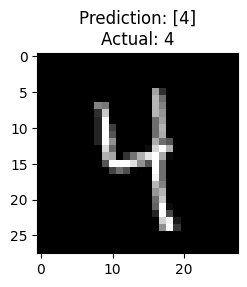

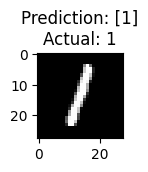

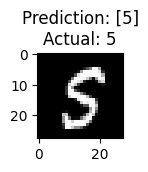

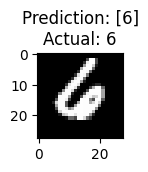

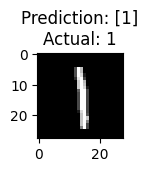

<Figure size 640x480 with 0 Axes>

In [29]:
def make_predictions(X, w1, b1, w2, b2):
    # Making predictions on the test data
    # we run forward prop and the function that sees which neuron has the highest probability
    # comparing it to the the actual label which allows us to determine the accuracy of the model
    # on new data.
    _, _, _, A2 = forward_prop(w1, b1, w2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def show_prediction(X, Y, index):
    # Reshape the image from (784,) to (28,28)
    current_image = X[:, index].reshape((28, 28)) * 255
    prediction = make_predictions(X[:, index].reshape(784, 1), w1, b1, w2, b2)
    
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f'Prediction: {prediction}\nActual: {Y[index]}')
    plt.show()

def get_accuracy(predictions, Y):
    # Print first few predictions and actual values for comparison
    print("First 10 predictions:", predictions[:10])
    print("First 10 actual values:", Y[:10])
    
    # Calculate and return accuracy
    accuracy = np.sum(predictions == Y) / Y.size
    print(f"\nTotal predictions made: {Y.size}")
    print(f"Correct predictions: {np.sum(predictions == Y)}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Test the model
test_predictions = make_predictions(X_test, w1, b1, w2, b2)
test_accuracy = get_accuracy(test_predictions, Y_test)

# Show confusion matrix (optional but helpful)
print("\nSample of predictions vs actual values:")
for i in range(10):
    print(f"Image {i}: Predicted={test_predictions[i]}, Actual={Y_test[i]}")

# Then show the visualizations as before
fig = plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_prediction(X_test, Y_test, i)
plt.tight_layout()
plt.show()